## Introduction

#### Import Libraries

In [1]:
import random, os
import pandas as pd
import numpy as np
import cv2
import imutils, re
from utils_lc import LCDataset, ToTensor, CNN, plot_confusion_matrix
from imutils import contours, perspective
import torch
import torch.nn as nn
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Setting Random Seed

In [2]:
seed = 2023
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

## Dataset

In [3]:
df = pd.read_csv("./Data/lc_metadata.csv")

#### Original Array

(3684, 4912, 3)


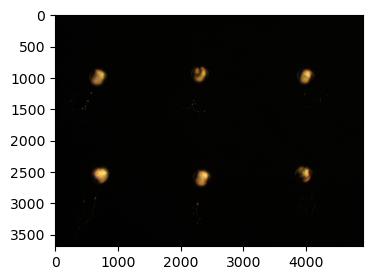

In [4]:
image = cv2.imread("./Data/a201_step01_sds_lc20x_spot001_cp.jpg")
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(6,3))
ax.imshow(image)
print(image.shape)

#### Droplet Detection

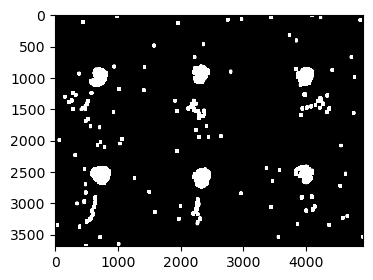

In [5]:
gauss_kernel = (9,9)
canny_tres = [30,50]
dilate_kernel = (7,7)
dilate_itr = 5
size_thres = [20000, 80000]
box_length = 200
image_transform = image.copy()
image_transform = cv2.GaussianBlur(image_transform,gauss_kernel,0)
image_transform = cv2.Canny(image_transform,canny_tres[0],canny_tres[1])
image_transform = cv2.dilate(image_transform,np.ones(dilate_kernel),iterations= dilate_itr)
fig, ax = plt.subplots(figsize=(6,3))
ax.imshow(image_transform, cmap="gray", vmin=0, vmax=1)

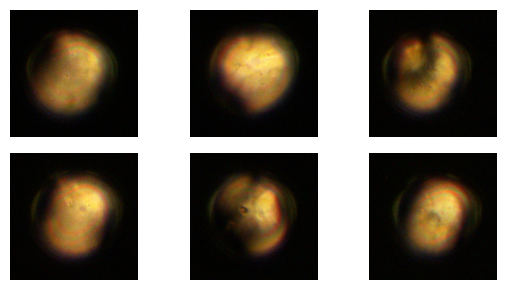

In [6]:
cnts = cv2.findContours(
    image_transform.copy(),
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
(cnts, _) = contours.sort_contours(cnts)
fig, ax = plt.subplots(2,3,figsize=(6,3))
count = 0
for c in cnts:
    i = count // 3
    j = count % 3
    if (cv2.contourArea(c) < size_thres[0]) | (cv2.contourArea(c) > size_thres[1]):
        continue
    box = cv2.boundingRect(c)
    width = round(box[2]/2)
    height = round(box[3]/2)
    center = (box[0]+width,box[1]+height)
    box = ((center[0]-box_length,center[1]-box_length), #top left
            (center[0]+box_length,center[1]-box_length), #top right
            (center[0]+box_length,center[1]+box_length), #bottom right
            (center[0]-box_length,center[1]+box_length)) #bottom left
    box = np.array(box, dtype="int")
    box = perspective.order_points(box)
    box = np.array(box, dtype="int")
    if (np.sum(box<0)>0) | (np.sum(box[:,0]>image.shape[1])>0) | (np.sum(box[:,1]>image.shape[0])>0):
        continue
    (tl, tr, br, bl) = box
    crop_img = image[tl[1]:br[1],tl[0]:br[0],:]
    ax[i,j].imshow(crop_img)
    ax[i,j].set_axis_off()
    count += 1
    plt.tight_layout()

#### Samples (Different Stimuli Concentrations)

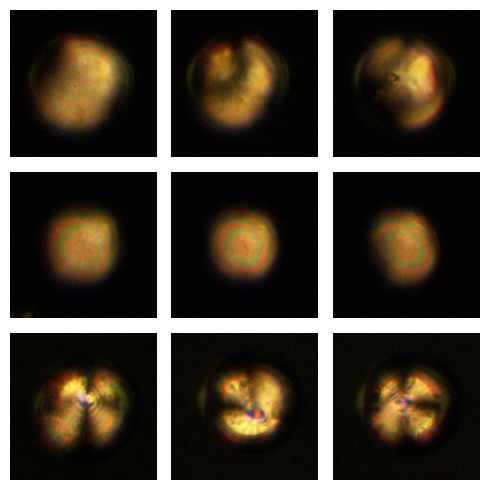

In [7]:
sample_id = ["a201_step01_sds_lc20x_spot001_cp_crop001.jpg", "a201_step01_sds_lc20x_spot001_cp_crop003.jpg", "a201_step01_sds_lc20x_spot001_cp_crop005.jpg",
             "a202_step02_sds_lc20x_spot001_cp_crop001.jpg", "a202_step02_sds_lc20x_spot001_cp_crop003.jpg", "a202_step02_sds_lc20x_spot001_cp_crop005.jpg",
             "a203_step03_sds_lc20x_spot001_cp_crop001.jpg", "a203_step03_sds_lc20x_spot001_cp_crop003.jpg", "a203_step03_sds_lc20x_spot001_cp_crop005.jpg"]
fig, ax = plt.subplots(3,3,figsize=(5,5))
count = 0
for i in range(3):
    for j in range(3):
        image = cv2.imread("./Data/lcdroplets/"+sample_id[count])
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        ax[i,j].imshow(image)
        ax[i,j].set_axis_off()
        count += 1
plt.tight_layout()

#### Image Augmentation

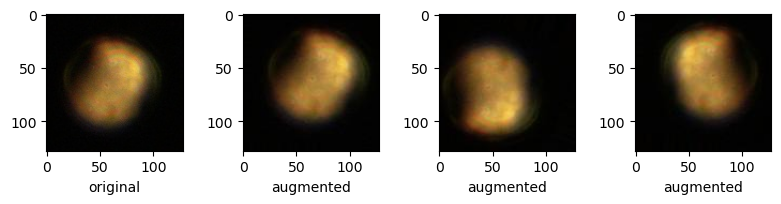

In [8]:
sample_id = "a201_step01_sds_lc20x_spot001_cp_crop001.jpg"
image = cv2.imread("./Data/lcdroplets/"+sample_id)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
imgaug = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
imgaug_number = 3
data = np.array(image)
data = data.reshape((1,) + data.shape)
prefix = re.sub(".jpg","",sample_id)
i = 0
for batch in imgaug.flow(
        data, batch_size=1,
        save_to_dir="./Data/lcdroplets/",
        save_prefix=prefix+"_aug",
        save_format='jpg',
        seed=seed):
    i += 1
    if i >= imgaug_number:
        break
fig, ax = plt.subplots(1,imgaug_number+1,figsize=(8,2))
ax[0].imshow(image)
ax[0].set_xlabel("original")
aug_imgs = [x for x in os.listdir("./Data/lcdroplets/") if "aug" in x][:imgaug_number]
for i,sample in enumerate(aug_imgs):
    image = cv2.imread("./Data/lcdroplets/"+sample)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    ax[i+1].imshow(image)
    ax[i+1].set_xlabel("augmented")
plt.tight_layout()

## Train a CNN Model

#### Model Setup and Training

In [9]:
batch_size = 5
lc_data = LCDataset(metadata="./Data/lc_metadata.csv", img_dir="./Data/lcdroplets/", transform=Compose([ToTensor()]),
    color_space='RGB', channel=[0,1,2], read_label=True)
train_idx, test_idx = train_test_split(range(len(lc_data)), test_size=0.1, random_state=seed, shuffle=True)
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
train_loader = torch.utils.data.DataLoader(lc_data, batch_size=batch_size,
                                            sampler=train_sampler,
                                            shuffle=False,
                                            drop_last=False)
test_loader = torch.utils.data.DataLoader(lc_data, batch_size=batch_size,
                                            sampler=test_sampler,
                                            shuffle=False,
                                            drop_last=False)

In [10]:
model = CNN(n_class=3,n_channel=3).cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

In [11]:
n_epoch = 30
train_losses = []
test_losses = []
for epoch in range(n_epoch):
    cur_train_loss = 0
    model.train()
    for data in train_loader:
        img = data["image"].cuda()
        lab = data["label"].view(-1,1).cuda()
        lab = lab.long().squeeze()
        optimizer.zero_grad()
        pred = model(img)
        loss = loss_fn(pred, lab)
        cur_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = cur_train_loss/len(train_loader)
    train_losses.append(avg_train_loss)
    cur_test_loss = 0
    model.eval()
    for data in test_loader:
        img = data["image"].cuda()
        lab = data["label"].view(-1,1).cuda()
        lab = lab.long().squeeze()
        pred = model(img)
        loss = loss_fn(pred, lab)
        cur_test_loss += loss.item()
    avg_test_loss = cur_test_loss/len(test_loader)
    test_losses.append(avg_test_loss)
    print("Epoch {}, train loss {:.3f}, test loss {:.3f}".format(epoch+1, avg_train_loss, avg_test_loss))


Epoch 1, train loss 0.882, test loss 0.643
Epoch 2, train loss 0.749, test loss 0.830
Epoch 3, train loss 0.736, test loss 0.529
Epoch 4, train loss 0.690, test loss 0.486
Epoch 5, train loss 0.645, test loss 0.931
Epoch 6, train loss 0.645, test loss 5.095
Epoch 7, train loss 0.690, test loss 0.518
Epoch 8, train loss 0.618, test loss 0.731
Epoch 9, train loss 0.626, test loss 0.376
Epoch 10, train loss 0.655, test loss 0.415
Epoch 11, train loss 0.602, test loss 0.377
Epoch 12, train loss 0.534, test loss 0.453
Epoch 13, train loss 0.542, test loss 0.988
Epoch 14, train loss 0.630, test loss 0.517
Epoch 15, train loss 0.603, test loss 0.456
Epoch 16, train loss 0.588, test loss 0.446
Epoch 17, train loss 0.504, test loss 0.405
Epoch 18, train loss 0.566, test loss 0.332
Epoch 19, train loss 0.507, test loss 0.311
Epoch 20, train loss 0.495, test loss 0.399
Epoch 21, train loss 0.555, test loss 0.345
Epoch 22, train loss 0.512, test loss 0.445
Epoch 23, train loss 0.475, test loss 0.3

#### Predict and Confusion Matrix

In [12]:
true_train, pred_train = [], []
true_test, pred_test = [], []
for idx in range(len(lc_data)):
    data = lc_data[idx]
    if idx in train_idx:
        true_train.append(data["label"].item())
        _, pred = torch.max(model(data["image"].unsqueeze(0).cuda()),1)
        pred_train.append(pred.item())
    else:
        true_test.append(data["label"].item())
        _, pred = torch.max(model(data["image"].unsqueeze(0).cuda()),1)
        pred_test.append(pred.item())

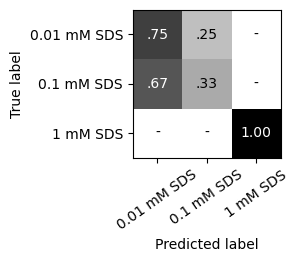

In [13]:
fig, ax = plt.subplots(figsize=(3,3))
plot_confusion_matrix(pred_test,true_test, 
                      labels=np.arange(3),display_labels=['0.01 mM SDS','0.1 mM SDS','1 mM SDS'],
                      cmap='gray_r',values_format='.2f',normalize='true',
                      xticks_rotation=35,
                      ax=ax)
plt.tight_layout()